In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import cv2
import os
from glob import glob
from tqdm import tqdm
from skimage.feature import hog
from skimage import exposure

In [2]:
train_path = '../data/train/'

### Load train data label file

In [3]:
df = pd.read_csv('./train_label.csv')
df.head()

,name,height,left,top,width,label
0,1.png,219,246,77,81,1
1,1.png,219,323,81,96,9
2,2.png,32,77,29,23,2
3,2.png,32,98,25,26,3
4,3.png,15,17,5,8,2


### Load train data

In [4]:
im = cv2.imread(os.path.join(train_path, '1.png'))

In [5]:
digits = df[df.name == '1.png']
digits

,name,height,left,top,width,label
0,1.png,219,246,77,81,1
1,1.png,219,323,81,96,9


In [6]:
top = digits.top.values[0]
left = digits.left.values[0]
width = digits.width.values[0]
height = digits.height.values[0]

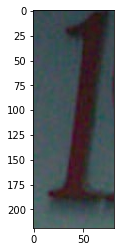

In [7]:
plt.imshow(im[top:top+height, left:left+width])
plt.show()

(219, 81)


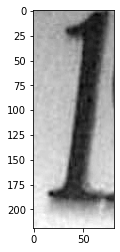

In [12]:
# Convert image to grayscale color
gray = cv2.cvtColor(im[top:top+height, left:left+width], cv2.COLOR_BGR2GRAY)
print(gray.shape)
plt.imshow(gray, cmap='gray')
plt.show()

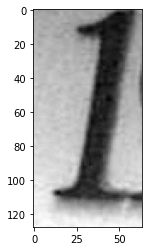

In [13]:
# Resize image
im_rsz = cv2.resize(gray, (64,128))
plt.imshow(im_rsz, cmap='gray')
plt.show()

In [14]:
fd, hog_image = hog(im_rsz, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True)

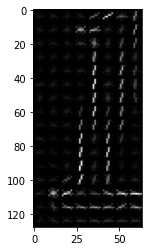

In [15]:
plt.imshow(hog_image, cmap='gray')
plt.show()

In [17]:
fd.shape

(3780,)

In [52]:
fd.shape

(108,)

In [13]:
hog_image.shape

(219, 96)

In [138]:
def gradient(im):
    """
    Compute magnitude and orientation of gradient
    @INPUT:
        - im: Image need to calculate gradient of each pixel
    @OUTPUT:
        - magnitude: magnitude of gradient
        - orientation: orientation of gradient
    """
    # Get image size
    m,n = im.shape
    
    # Convert to float
    im = im.astype(float)
    # Compute magnitude and orientation of gradient
    gx = np.zeros((m,n))
    gx[1:-1,:] = im[2:,:] - im[:-2,:]
    gy = np.zeros((m,n))
    gy[:,1:-1] = im[:,2:] - im[:,:-2]
    
    magnitude = np.sqrt(gx**2+gy**2)
    orientation = np.arctan2(gy,gx)*180/np.pi % 180
    
#     return gx, gy
    return magnitude, orientation
    

In [153]:
def calculate_hist(magnitude, orientation, cell_size=8, bins=9):
    # Calculate number of cells in block
    h, w = magnitude.shape
    nh = np.int(h/cell_size)
    nw = np.int(w/cell_size)
    
    # Init block histogram
    blk_hist = []
    
    # Calculate histogram for each cell
    for i in range(nh):
        for j in range(nw):
            cell_mag = magnitude[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]
            cell_ori = orientation[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]
    
            # Init histogram for each cell
            hist = np.zeros(bins)
            step = 180/bins
            threshold = np.arange(0,180,step)
            
            # Change matrix to vector
            cell_mag = cell_mag.ravel()
            cell_ori = cell_ori.ravel()

            # Calculate weight for each bin
            for (mag, ori) in zip(cell_mag, cell_ori):
                l = np.where(threshold <= ori)[0][-1]
                if l == bins-1:
                    r = 0
                else:
                    r = l + 1
                
                hist[r] += (ori - threshold[l])/step * mag
                hist[l] += (threshold[l] + step - ori)/step * mag
                
            blk_hist = np.concatenate((blk_hist, hist))
    
    # Normalize histogram
    blk_hist = blk_hist/np.linalg.norm(blk_hist)
    
    return blk_hist

In [148]:
def hog_extract(im):
    """
    Histogram of Oriented Gradient feature extract.
    """
    # Get image size
    h,w = im.shape
    
    # Calculate magnitude and orientation of gradient
    magnitude, orientation = gradient(im)
    
    # Number of cell in width and height
    cell_size = 8
    nh = np.int(h/cell_size)
    nw = np.int(w/cell_size)
    
    # Init HOG
    hog = []
    
    # Calculate HOG
    for i in range(nh-1):
        for j in range(nw-1):
            cell_mag = magnitude[i*cell_size:(i+2)*cell_size, j*cell_size:(j+2)*cell_size]
            cell_ori = magnitude[i*cell_size:(i+2)*cell_size, j*cell_size:(j+2)*cell_size]
            blk_hist = calculate_hist(cell_mag, cell_ori, cell_size)
            hog = np.concatenate((hog, blk_hist))
    
    return hog

In [154]:
tmp = hog_extract(im_rsz)

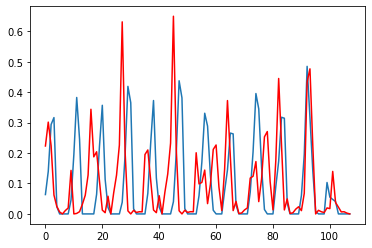

In [155]:
plt.plot(tmp)
plt.plot(fd, 'r')
plt.show()